<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/resnet50_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d mohamedeldakrory8/ecg-heart-categorization-dataset-image-version

100% 486M/486M [00:25<00:00, 23.5MB/s]
100% 486M/486M [00:25<00:00, 20.2MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-heart-categorization-dataset-image-version.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!rm /content/ECG_Image_data/train/F/*
!rmdir /content/ECG_Image_data/train/F

rm: cannot remove '/content/ECG_Image_data/train/F/*': No such file or directory
rmdir: failed to remove '/content/ECG_Image_data/train/F': No such file or directory


In [ ]:
!rm /content/ECG_Image_data/test/F/*
!rmdir /content/ECG_Image_data/test/F

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob

In [ ]:
train_dir = Path('/content/ECG_Image_data/train')
test_dir = Path('/content/ECG_Image_data/test')

In [ ]:
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/N/39463.jpg,N
1,/content/ECG_Image_data/train/N/28891.jpg,N
2,/content/ECG_Image_data/train/N/4725.jpg,N
3,/content/ECG_Image_data/train/N/34182.jpg,N
4,/content/ECG_Image_data/train/N/19532.jpg,N
...,...,...
97131,/content/ECG_Image_data/train/M/1581.jpg,M
97132,/content/ECG_Image_data/train/M/5394.jpg,M
97133,/content/ECG_Image_data/train/M/2473.jpg,M
97134,/content/ECG_Image_data/train/M/3989.jpg,M


In [ ]:
dataframe['Label'].value_counts()

N             72471
M              8000
Q              6431
V              5788
S              2223
F-resample     2223
Name: Label, dtype: int64

In [ ]:
train_samples = []
for category in dataframe['Label'].unique():
    train_category = dataframe.query("Label == @category")
    train_samples.append(train_category.sample(1000, random_state=1))

dataframe_train = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Q             1000
S             1000
V             1000
F-resample    1000
N             1000
M             1000
Name: Label, dtype: int64

In [ ]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/Q/1013.jpg,Q
1,/content/ECG_Image_data/train/S/1741.jpg,S
2,/content/ECG_Image_data/train/S/572.jpg,S
3,/content/ECG_Image_data/train/V/3903.jpg,V
4,/content/ECG_Image_data/train/V/1696.jpg,V
...,...,...
5995,/content/ECG_Image_data/train/N/38861.jpg,N
5996,/content/ECG_Image_data/train/M/3678.jpg,M
5997,/content/ECG_Image_data/train/V/3780.jpg,V
5998,/content/ECG_Image_data/train/N/49469.jpg,N


In [ ]:
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/N/4725.jpg,N
1,/content/ECG_Image_data/test/N/6880.jpg,N
2,/content/ECG_Image_data/test/N/14959.jpg,N
3,/content/ECG_Image_data/test/N/15932.jpg,N
4,/content/ECG_Image_data/test/N/1207.jpg,N
...,...,...
24787,/content/ECG_Image_data/test/M/2120.jpg,M
24788,/content/ECG_Image_data/test/M/1765.jpg,M
24789,/content/ECG_Image_data/test/M/1581.jpg,M
24790,/content/ECG_Image_data/test/M/2473.jpg,M


In [ ]:
dataframe_test['Label'].value_counts()

N              18118
M               2506
Q               1608
V               1448
S                556
F-resampled      556
Name: Label, dtype: int64

In [ ]:
test_samples = []
for category in dataframe_test['Label'].unique():
    test_category = dataframe_test.query("Label == @category")
    test_samples.append(test_category.sample(300, random_state=1))

dataframe_test = pd.concat(test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

V              300
Q              300
S              300
F-resampled    300
N              300
M              300
Name: Label, dtype: int64

In [ ]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/V/1206.jpg,V
1,/content/ECG_Image_data/test/Q/148.jpg,Q
2,/content/ECG_Image_data/test/S/35.jpg,S
3,/content/ECG_Image_data/test/V/898.jpg,V
4,/content/ECG_Image_data/test/F-resampled/257.jpg,F-resampled
...,...,...
1795,/content/ECG_Image_data/test/F-resampled/254.jpg,F-resampled
1796,/content/ECG_Image_data/test/M/1749.jpg,M
1797,/content/ECG_Image_data/test/F-resampled/54.jpg,F-resampled
1798,/content/ECG_Image_data/test/N/4656.jpg,N


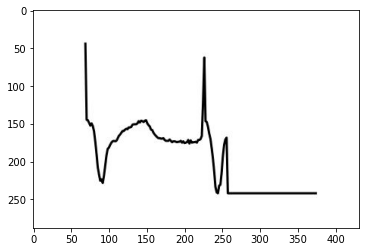

In [ ]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [ ]:
array_image = img_to_array(img)
print(array_image.shape)

(288, 432, 3)


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255,
    #shear_range = 0.2,
    #horizontal_flip=True,
    #zoom_range = 0.2,
    validation_split=0.25
  
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4500 validated image filenames belonging to 6 classes.
Found 1500 validated image filenames belonging to 6 classes.
Found 1800 validated image filenames belonging to 6 classes.


In [ ]:
test_generator.class_indices

{'F-resampled': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

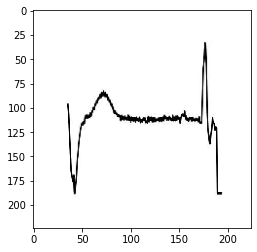

In [ ]:
plt.imshow(test_generator[0][0][3])

In [ ]:
folders=glob('/content/ECG_Image_data/test/*')
folders

['/content/ECG_Image_data/test/N',
 '/content/ECG_Image_data/test/Q',
 '/content/ECG_Image_data/test/S',
 '/content/ECG_Image_data/test/F-resampled',
 '/content/ECG_Image_data/test/V',
 '/content/ECG_Image_data/test/M']

In [ ]:
IMAGE_SIZE = [224, 224]
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
resnet_model = Model(inputs=resnet.input, outputs=prediction)

resnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
result=resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[checkpoint]
)

Epoch 1/25
141/141 [==============================] - ETA: 0s - loss: 1.8115 - accuracy: 0.5669
Epoch 1: val_accuracy improved from -inf to 0.76267, saving model to best_model.h5
141/141 [==============================] - 28s 175ms/step - loss: 1.8115 - accuracy: 0.5669 - val_loss: 0.6732 - val_accuracy: 0.7627
Epoch 2/25
141/141 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.7453
Epoch 2: val_accuracy improved from 0.76267 to 0.79067, saving model to best_model.h5
141/141 [==============================] - 21s 152ms/step - loss: 0.7302 - accuracy: 0.7453 - val_loss: 0.5466 - val_accuracy: 0.7907
Epoch 3/25
141/141 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.7764
Epoch 3: val_accuracy did not improve from 0.79067
141/141 [==============================] - 21s 149ms/step - loss: 0.6595 - accuracy: 0.7764 - val_loss: 0.7017 - val_accuracy: 0.7520
Epoch 4/25
141/141 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0

In [ ]:
resnet_model.save('best.h5')

In [ ]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.47425
Test Accuracy: 88.22%


In [ ]:
from keras.models import load_model
best_model1=load_model('/content/best.h5')
results1 = best_model1.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.48902
Test Accuracy: 85.89%


Text(0, 0.5, 'loss')

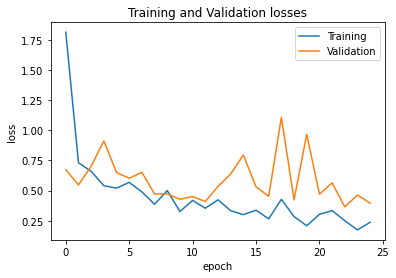

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

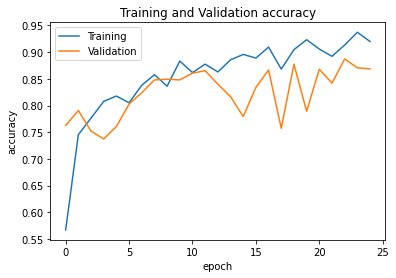

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
y_pred = best_model.predict(test_generator)
y_pred

57/57 [==============================] - 9s 110ms/step


array([[2.3206033e-09, 2.9167661e-03, 1.2650832e-03, 3.2742921e-07,
        9.8535359e-01, 1.0464255e-02],
       [6.4371777e-13, 3.2576750e-10, 9.1790819e-10, 1.0000000e+00,
        5.8422078e-10, 5.2276100e-10],
       [1.7630908e-10, 3.7798658e-04, 4.9558264e-05, 2.1858809e-10,
        9.9957246e-01, 1.1534756e-08],
       ...,
       [9.9997592e-01, 9.2645114e-06, 9.8812261e-06, 2.2042875e-07,
        4.4807980e-06, 1.8045581e-07],
       [5.2687024e-06, 1.3654577e-02, 9.2347574e-01, 2.8887422e-12,
        5.4620828e-02, 8.2436334e-03],
       [9.9998963e-01, 2.1542437e-08, 3.4701698e-06, 9.0907811e-12,
        1.9779653e-08, 6.8835679e-06]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([4, 3, 4, ..., 0, 2, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[291   0   0   0   0   9]
 [  9 249  32   3   3   4]
 [ 21  10 252   0  12   5]
 [  2   7   1 284   3   3]
 [ 13  10  32   0 239   6]
 [ 18   2   2   3   2 273]]
classification report
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       300
           1       0.90      0.83      0.86       300
           2       0.79      0.84      0.81       300
           3       0.98      0.95      0.96       300
           4       0.92      0.80      0.86       300
           5       0.91      0.91      0.91       300

    accuracy                           0.88      1800
   macro avg       0.89      0.88      0.88      1800
weighted avg       0.89      0.88      0.88      1800



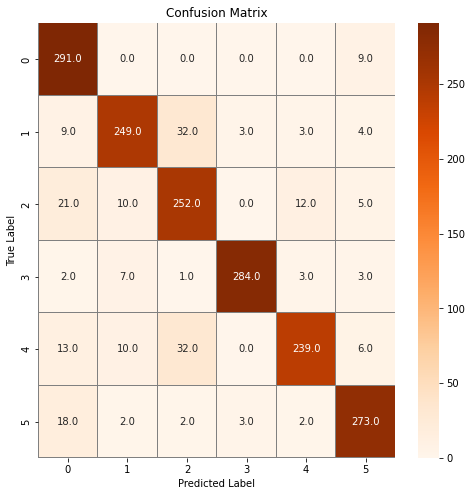

In [ ]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F-resample', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 0s 25ms/step


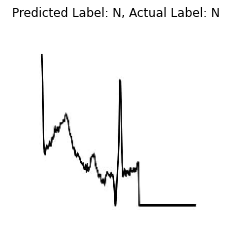

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/N/10015.jpg'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='N')